# This notebook is analzying the spectral parameters from the EEG data pre and post ECT.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from scipy.stats import zscore
from pingouin import ttest, normality, wilcoxon
from cliffs_delta import cliffs_delta

from ect_plotting_functions import plot_feature_prepost
from matplotlib import rcParams
rcParams['font.family'] = 'Helvetica'

%matplotlib inline

In [2]:
# Load dataframe
eeg_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)
# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

## Load SpecParam Fits and PSDs

In [77]:
# Fits
fits_pre = np.load('../saved_files/ect_files/fits_pre.npy')
fits_post = np.load('../saved_files/ect_files/fits_post.npy')
freq_axis = np.load('../saved_files/ect_files/freq_axis.npy')
# PSDs
psd_pre = np.load('../saved_files/ect_files/pre_ect_psd.npy')
psd_post = np.load('../saved_files/ect_files/post_ect_psd.npy')

**Delete excluded electrodes per patient in the model fits**

In order to do this, we load the dataframe (eeg_df_included) and the fits (fits_pre, fits_post).

Then, we need to reshape the fits to match the dataframe.

After excluding the fits, we will reshape it back to its' original shape.

In [78]:
# Get boolean area with True to exclude channels from patients
to_exclude_pre = eeg_df['exclude'][eeg_df['pre_post']=='pre'].values
to_exclude_post = eeg_df['exclude'][eeg_df['pre_post']=='post'].values

# Reshape fits and PSDs array from [NUM_PATIENTS, NUM_CHANNELS, NUM_FREQS] --> [NUM_PATIENTS * NUM_CHANNELS, NUM_FREQS]
fits_pre_flat = fits_pre.reshape(len(to_exclude_pre), fits_pre.shape[2])
fits_post_flat = fits_post.reshape(len(to_exclude_pre), fits_pre.shape[2])
psd_pre_flat = psd_pre.reshape(len(to_exclude_pre), psd_pre.shape[2])
psd_post_flat = psd_post.reshape(len(to_exclude_pre), psd_pre.shape[2])

# Replace to excluded ones with nans
fits_pre_flat[to_exclude_pre] = np.nan
fits_post_flat[to_exclude_post] = np.nan
psd_pre_flat[to_exclude_pre] = np.nan
psd_post_flat[to_exclude_post] = np.nan

# Reshape back to original array from  [NUM_PATIENTS * NUM_CHANNELS, NUM_FREQS] --> [NUM_PATIENTS, NUM_CHANNELS, NUM_FREQS]
fits_pre_included = fits_pre_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
fits_post_included = fits_post_flat.reshape(fits_pre.shape[0], fits_pre.shape[1], fits_pre.shape[2])
psd_pre_included = psd_pre_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])
psd_post_included = psd_post_flat.reshape(psd_pre.shape[0], psd_pre.shape[1], psd_pre.shape[2])

## Averaging Over All Electrodes Per Subject

In [4]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_bw', 'alpha_cf']
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

## Plot pre/post differences

## Calculate Delta, Theta, and Alpha Percentage Per Subject

In [5]:
def compute_abundance(df, feature=''):
    """computes abundance as the number of channels containing an oscillation/total channels
    Parameters
    ----------
    Returns
    -------
    """
    features = ['patient','pre_post','channel', feature+'_cf']
    df_osc = pd.DataFrame(df[features])
    df_osc[f'{feature}_present'] = df_osc[feature+'_cf'].notna()
    ch_osc = df_osc.groupby(['patient', 'pre_post'])[f'{feature}_present'].sum().values
    ch_total = df_osc.groupby(['patient', 'pre_post'])['channel'].count().values
    ch_osc_perc = ch_osc/ch_total
    osc_perc_df = pd.DataFrame(df_osc.groupby(['patient', 'pre_post'], as_index=False)[f'{feature}_present'].sum())
    osc_perc_df[f'ch_{feature}_perc'] = ch_osc_perc
    
    return osc_perc_df

In [6]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [7]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [8]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## Plot pre/post differences

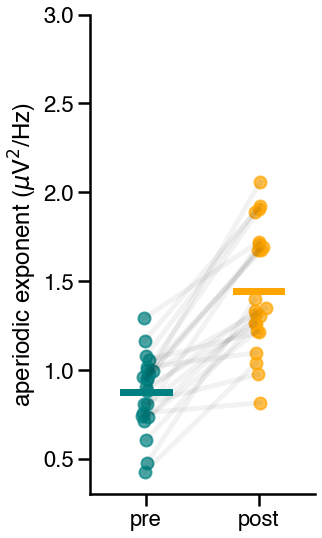

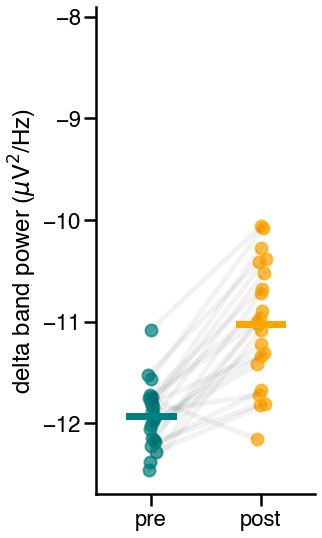

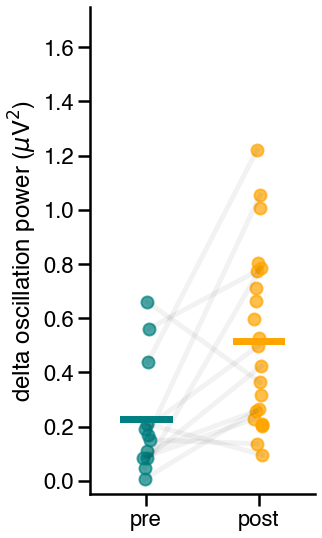

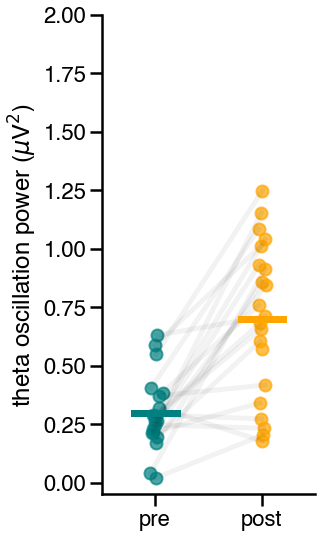

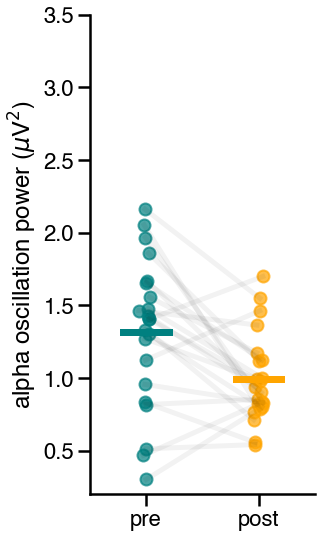

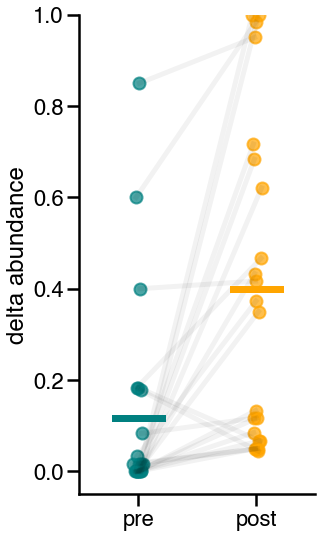

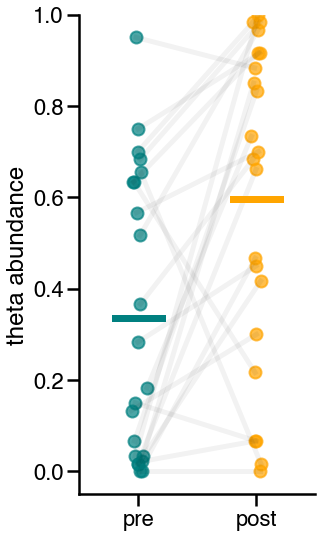

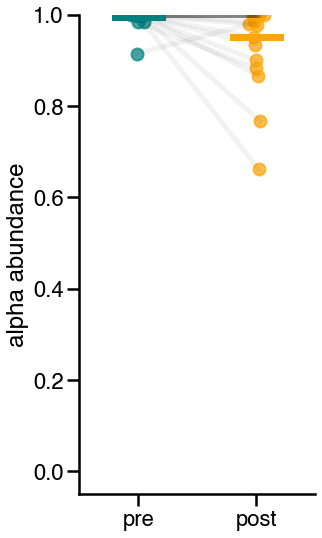

In [12]:
SAVE_FIG = False
fig_path = '../figures/'

# %matplotlib qt

features = ['exponent', 'delta_bp', 'delta_amp', 'theta_amp', 'alpha_amp',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

labels = ['aperiodic exponent ($\mu$V$^2$/Hz)','delta band power ($\mu$V$^2$/Hz)', 
          'delta oscillation power ($\mu$V$^2$)', 'theta oscillation power ($\mu$V$^2$)', 
          'alpha oscillation power ($\mu$V$^2$)',
          'delta abundance', 'theta abundance', 'alpha abundance']

ylims = [(0.3, 3.0), (-12.7, -7.9), (-0.05, 1.75), (-0.05, 2.0), (0.2, 3.5), 
         (-0.05, 1.0), (-0.05, 1.0), (-0.05, 1.0)]



for feature, label, ylim in zip(features, labels, ylims):
    plot_feature_prepost(eeg_df_mean, feature=feature)
    plt.ylabel(label)
    plt.ylim(ylim)
    plt.tight_layout()
    sns.despine()
    plt.show()
    
    if SAVE_FIG:
        plt.savefig(fig_path+feature+'.pdf', format='pdf')

## Plot SpecParam fits

In [79]:
fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
fits_post_mean = np.nanmean(fits_post_included, axis=1)

fits_pre_grand_mean = np.nanmean(fits_pre_included, axis=(0,1))
fits_post_grand_mean = np.nanmean(fits_post_included, axis=(0,1))

/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_69959/1731462785.py:1: RuntimeWarning: Mean of empty slice
  fits_pre_mean = np.nanmean(fits_pre_included, axis=1)
/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_69959/1731462785.py:2: RuntimeWarning: Mean of empty slice
  fits_post_mean = np.nanmean(fits_post_included, axis=1)


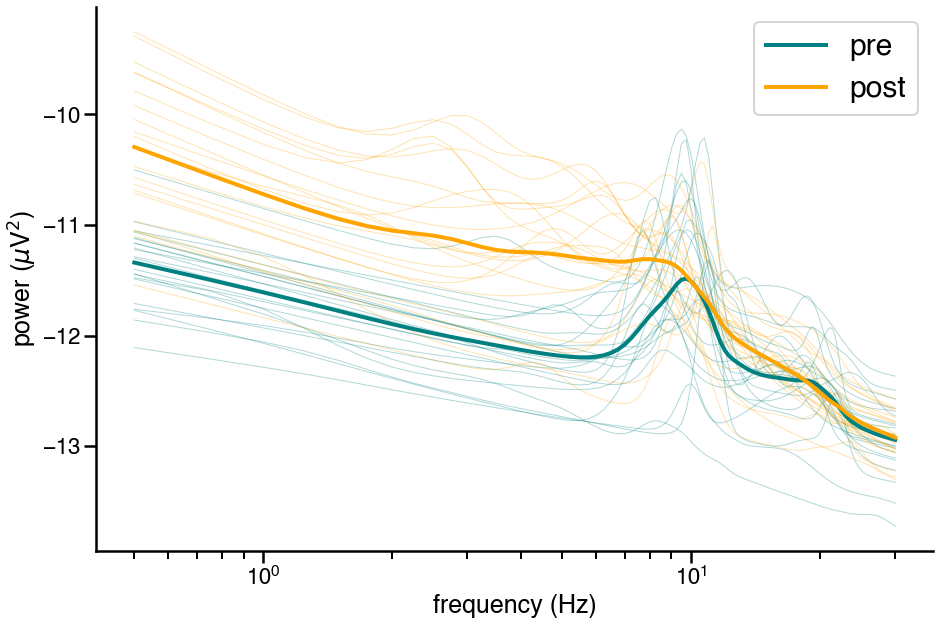

In [80]:
SAVE_FIG = False

sns.set_context('poster')
plt.figure(figsize=[15,10])

# plot patient pre
for patient in range(0, fits_pre_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_pre_mean[patient], color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, fits_post_mean.shape[0]):
    plt.plot(freq_axis[2:121], fits_post_mean[patient], color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[2:121], fits_pre_grand_mean, color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[2:121], fits_post_grand_mean, color='orange', linewidth = 4, label='post')

plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})
sns.despine()
plt.show()

if SAVE_FIG:
    plt.savefig(fig_path+'spectra_fits.pdf', format='pdf')

## Plot Spectra (raw PSDs)

In [81]:
psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
psd_post_mean = np.nanmean(psd_post_included, axis=1)

psd_pre_grand_mean = np.nanmean(psd_pre_included, axis=(0,1))
psd_post_grand_mean = np.nanmean(psd_post_included, axis=(0,1))

/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_69959/4288182120.py:1: RuntimeWarning: Mean of empty slice
  psd_pre_mean = np.nanmean(psd_pre_included, axis=1)
/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_69959/4288182120.py:2: RuntimeWarning: Mean of empty slice
  psd_post_mean = np.nanmean(psd_post_included, axis=1)


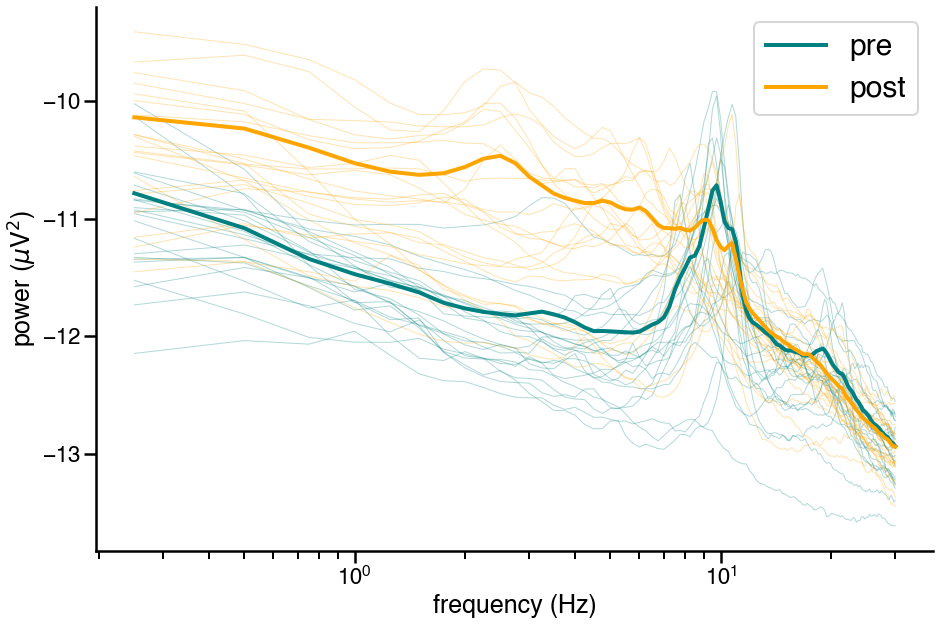

In [82]:
# plot patient pre
SAVE_FIG = False

sns.set_context('poster')
plt.figure(figsize=[15,10])

for patient in range(0, psd_pre_mean.shape[0]):
    plt.plot(freq_axis[1:121], np.log10(psd_pre_mean[patient,1:121]), color='teal', alpha = 0.3, linewidth = 1)

# plot patient post
for patient in range(0, psd_post_mean.shape[0]):
    plt.plot(freq_axis[1:121], np.log10(psd_post_mean[patient,1:121]), color='orange', alpha = 0.3, linewidth = 1)

# plot average pre
plt.plot(freq_axis[1:121], np.log10(psd_pre_grand_mean[1:121]), color='teal', linewidth = 4, label='pre')

# plot average post
plt.plot(freq_axis[1:121], np.log10(psd_post_grand_mean[1:121]), color='orange', linewidth = 4, label='post')

plt.xscale('log')
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.ylabel("power ($\mu$V$^2$)", fontsize = 25)
plt.xlabel("frequency (Hz)", fontsize = 25)
plt.legend(prop = {'size': 30})
sns.despine()
plt.show()

if SAVE_FIG:
    plt.savefig(fig_path+'raw_spectra.pdf', format='pdf')

# Statistics

### Exponent: Pre/Post

**Normality**

In [18]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['exponent'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['exponent'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.971783  0.751975    True
          W     pval  normal
0  0.953723  0.37355    True


**Descriptive**

In [19]:
print('exponent pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['exponent'].describe())

exponent pre:
count    22.000000
mean      0.877277
std       0.210306
min       0.427745
25%       0.744020
50%       0.925695
75%       0.999571
max       1.291168
Name: exponent, dtype: float64


In [20]:
print('exponent post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['exponent'].describe())

exponent post:
count    22.000000
mean      1.446456
std       0.342854
min       0.814813
25%       1.227595
50%       1.340461
75%       1.705137
max       2.056384
Name: exponent, dtype: float64


**T-Test**

In [21]:
print(ttest(means_pre, means_post, paired=True))

               T  dof alternative         p-val          CI95%   cohen-d  \
T-test -9.066168   21   two-sided  1.047680e-08  [-0.7, -0.44]  2.001261   

             BF10  power  
T-test  1.218e+06    1.0  


### Delta Oscillatory Power: Pre/Post

**Normality**

In [33]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_amp'].values # .dropna(how="any")
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_amp'].values

# # normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.835536  0.024446   False
          W      pval  normal
0  0.927464  0.108642    True


**Descriptive**

In [34]:
print('delta osc pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_amp'].describe())

delta osc pre:
count    12.000000
mean      0.226376
std       0.210853
min       0.007236
25%       0.084549
50%       0.160900
75%       0.266959
max       0.660009
Name: delta_amp, dtype: float64


In [35]:
print('delta osc post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_amp'].describe())

delta osc post:
count    22.000000
mean      0.515698
std       0.324592
min       0.095825
25%       0.234924
50%       0.460372
75%       0.758967
max       1.220475
Name: delta_amp, dtype: float64


**Wilcoxon**

In [38]:
print(wilcoxon(means_pre, means_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon   10.0   two-sided  0.020996 -0.74359  0.222222


**Cliffs Delta**

In [39]:
cliffs_delta(means_pre, means_post)

(-0.2644628099173554, 'small')

### Delta Bandpower: Pre/Post

**Normality**

In [23]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_bp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.964059  0.575385    True
          W      pval  normal
0  0.971237  0.739519    True


**Descriptive**

In [25]:
print('delta bandpower pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['delta_bp'].describe())

delta bandpower pre:
count    22.000000
mean    -11.924393
std       0.316030
min     -12.462645
25%     -12.162811
50%     -11.913029
75%     -11.749547
max     -11.080814
Name: delta_bp, dtype: float64


In [26]:
print('delta bandpower post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['delta_bp'].describe())

delta bandpower post:
count    22.000000
mean    -11.026037
std       0.596960
min     -12.158437
25%     -11.401423
50%     -11.016567
75%     -10.557999
max     -10.061906
Name: delta_bp, dtype: float64


**T-Test**

In [27]:
print(ttest(means_pre, means_post, paired=True))

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.269111   21   two-sided  4.825668e-08  [-1.12, -0.67]  1.880913   

             BF10  power  
T-test  2.944e+05    1.0  


### Theta Oscillatory Power: Pre/Post

**Normality**

In [28]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_amp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.937012  0.210426    True
          W      pval  normal
0  0.951922  0.370155    True


**Descriptive**

In [29]:
print('theta oscillatory pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_amp'].describe())

theta oscillatory pre:
count    20.000000
mean      0.298130
std       0.158243
min       0.019979
25%       0.214535
50%       0.273490
75%       0.374266
max       0.629142
Name: theta_amp, dtype: float64


In [30]:
print('theta oscillatory post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_amp'].describe())

theta oscillatory post:
count    21.000000
mean      0.700664
std       0.329482
min       0.178038
25%       0.417039
50%       0.710118
75%       0.931667
max       1.245374
Name: theta_amp, dtype: float64


**T-Test**

In [31]:
print(ttest(means_pre, means_post, paired=True))

              T  dof alternative     p-val           CI95%  cohen-d      BF10  \
T-test -5.65128   19   two-sided  0.000019  [-0.56, -0.26]  1.55462  1235.394   

        power  
T-test    1.0  


### Theta Bandpower: Pre/Post

**Normality**

In [33]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_bp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

         W      pval  normal
0  0.97969  0.911075    True
          W      pval  normal
0  0.919864  0.075529    True


**Descriptive**

In [34]:
print('theta bandpower pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['theta_bp'].describe())

theta bandpower pre:
count    22.000000
mean    -12.174762
std       0.407343
min     -12.938969
25%     -12.381033
50%     -12.183001
75%     -11.863502
max     -11.331101
Name: theta_bp, dtype: float64


In [35]:
print('theta bandpower post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['theta_bp'].describe())

theta bandpower post:
count    22.000000
mean    -11.254515
std       0.594615
min     -12.431311
25%     -11.517969
50%     -11.151232
75%     -10.791764
max     -10.484897
Name: theta_bp, dtype: float64


**T-Test**

In [36]:
print(ttest(means_pre, means_post, paired=True))

               T  dof alternative         p-val           CI95%   cohen-d  \
T-test -8.485694   21   two-sided  3.160559e-08  [-1.15, -0.69]  1.805628   

             BF10  power  
T-test  4.361e+05    1.0  


### Alpha Oscillatory Power: Pre/Post

**Normality**

In [37]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_amp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_amp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.962978  0.551718    True
          W      pval  normal
0  0.927036  0.106438    True


In [38]:
print('alpha oscillatory pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_amp'].describe())

alpha oscillatory pre:
count    22.000000
mean      1.318737
std       0.506624
min       0.302655
25%       0.998007
50%       1.404595
75%       1.630004
max       2.160562
Name: alpha_amp, dtype: float64


In [39]:
print('alpha oscillatory post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_amp'].describe())

alpha oscillatory post:
count    22.000000
mean      0.990776
std       0.304755
min       0.541947
25%       0.805086
50%       0.919895
75%       1.123028
max       1.698439
Name: alpha_amp, dtype: float64


**T-Test**

In [40]:
print(ttest(means_pre, means_post, paired=True))

               T  dof alternative     p-val         CI95%  cohen-d    BF10  \
T-test  3.331855   21   two-sided  0.003165  [0.12, 0.53]  0.78449  13.197   

           power  
T-test  0.939035  


### Alpha Bandpower: Pre/Post

**Normality**

In [41]:
means_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_bp'].values
means_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_bp'].values

# normality test
print(normality(means_pre, method='shapiro'))
print(normality(means_post, method='shapiro'))

          W      pval  normal
0  0.975177  0.826532    True
          W      pval  normal
0  0.978059  0.883132    True


In [42]:
print('alpha bandpower pre:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['alpha_bp'].describe())

alpha bandpower pre:
count    22.000000
mean    -11.585906
std       0.598671
min     -12.915078
25%     -11.986883
50%     -11.552674
75%     -11.143406
max     -10.606282
Name: alpha_bp, dtype: float64


In [43]:
print('alpha bandpower post:')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['alpha_bp'].describe())

alpha bandpower post:
count    22.000000
mean    -11.384800
std       0.366248
min     -12.115812
25%     -11.584944
50%     -11.359876
75%     -11.169821
max     -10.633544
Name: alpha_bp, dtype: float64


**T-Test**

In [44]:
print(ttest(means_pre, means_post, paired=True))

               T  dof alternative     p-val        CI95%   cohen-d   BF10  \
T-test -2.064271   21   two-sided  0.051564  [-0.4, 0.0]  0.405245  1.311   

           power  
T-test  0.441951  


### Delta Abundance: Pre/Post

**Normality**

In [45]:
perc_delta_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_delta_perc'].values
perc_delta_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_delta_perc'].values

# normality test
print(normality(perc_delta_pre, method='shapiro'))
print(normality(perc_delta_post, method='shapiro'))

          W      pval  normal
0  0.601801  0.000001   False
          W      pval  normal
0  0.844232  0.002689   False


**Descriptive**

In [46]:
# pre delta abundance descrition:
print('pre delta abundance')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_delta_perc'].describe())

pre delta abundance
count    22.000000
mean      0.117197
std       0.223432
min       0.000000
25%       0.000000
50%       0.016667
75%       0.154167
max       0.850000
Name: ch_delta_perc, dtype: float64


In [47]:
# post delta abundance descrition:
print('post delta abundance')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_delta_perc'].describe())

post delta abundance
count    22.000000
mean      0.398778
std       0.355102
min       0.044444
25%       0.071277
50%       0.361441
75%       0.667672
max       1.000000
Name: ch_delta_perc, dtype: float64


**Wilcoxon Test**

In [86]:
print(wilcoxon(perc_delta_pre, perc_delta_post))

          W-val alternative     p-val       RBC      CLES
Wilcoxon   20.5   two-sided  0.000177 -0.837945  0.167355


In [87]:
cliffs_delta(perc_delta_pre, perc_delta_post)

(-0.6652892561983471, 'large')

### Theta Abundance: Pre/Post

**Normality**

In [51]:
perc_theta_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_theta_perc'].values
perc_theta_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_theta_perc'].values

# normality test
print(normality(perc_theta_pre, method='shapiro'))
print(normality(perc_theta_post, method='shapiro'))

          W      pval  normal
0  0.866219  0.006662   False
          W      pval  normal
0  0.883899  0.014351   False


**Descriptive**

In [49]:
# pre delta abundance descrition:
print('pre theta abundance')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_theta_perc'].describe())

pre theta abundance
count    22.000000
mean      0.336107
std       0.312633
min       0.000000
25%       0.033333
50%       0.233333
75%       0.633333
max       0.950000
Name: ch_theta_perc, dtype: float64


In [50]:
# post delta abundance descrition:
print('post theta abundance')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_theta_perc'].describe())

post theta abundance
count    22.000000
mean      0.595981
std       0.352105
min       0.000000
25%       0.329167
50%       0.691667
75%       0.908333
max       1.000000
Name: ch_theta_perc, dtype: float64


**Wilcoxon Test**

In [52]:
print(wilcoxon(perc_theta_pre, perc_theta_post))

          W-val alternative     p-val      RBC      CLES
Wilcoxon   35.0   two-sided  0.005422 -0.69697  0.274793
          W      pval  normal
0  0.866219  0.006662   False
          W      pval  normal
0  0.883899  0.014351   False


/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [98]:
cliffs_delta(perc_theta_pre, perc_theta_post)

(-0.45041322314049587, 'medium')

### Alpha Abundance: Pre/Post

**Normality**

In [56]:
perc_alpha_pre = eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_alpha_perc'].values
perc_alpha_post = eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_alpha_perc'].values

# normality test
print(normality(perc_alpha_pre, method='shapiro'))
print(normality(perc_alpha_post, method='shapiro'))

          W          pval  normal
0  0.331886  4.845977e-09   False
          W      pval  normal
0  0.645964  0.000004   False


**Descriptive**

In [54]:
print('alpha abundance pre')
print(eeg_df_mean[eeg_df_mean['pre_post']=='pre']['ch_alpha_perc'].describe())

alpha abundance pre
count    22.000000
mean      0.994604
std       0.018475
min       0.914894
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


In [55]:
print('alpha abundance post')
print(eeg_df_mean[eeg_df_mean['pre_post']=='post']['ch_alpha_perc'].describe())

alpha abundance post
count    22.000000
mean      0.950039
std       0.088371
min       0.661017
25%       0.937500
50%       1.000000
75%       1.000000
max       1.000000
Name: ch_alpha_perc, dtype: float64


**Wilcoxon Test**

In [108]:
print(wilcoxon(perc_alpha_pre, perc_alpha_post))
print(normality(perc_alpha_pre, method='shapiro'))
print(normality(perc_alpha_post, method='shapiro'))

          W-val alternative     p-val       RBC      CLES
Wilcoxon    4.0   two-sided  0.018981  0.854545  0.676653
          W          pval  normal
0  0.331886  4.845977e-09   False
          W      pval  normal
0  0.645964  0.000004   False


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [109]:
cliffs_delta(perc_alpha_pre, perc_alpha_post)

(0.35330578512396693, 'medium')

## Multiple Regression Spectral Analysis

What EEG features may be predictive of other EEG features? Specifically, what might be driving the bandpower differences pre vs. post?

### Using Treatment Difference

**Take difference of pre - post**

In [59]:
# Take features of interest + average over all electrodes per patient
features = ['exponent', 'offset', 'delta_amp', 'delta_bp', 'theta_amp', 'theta_bp', 'theta_cf', 'delta_cf',
            'alpha_amp', 'alpha_bp', 'alpha_cf', 'ch_theta_perc', 'ch_delta_perc', 'ch_alpha_perc']


diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')
diff_df_mean['patient'] = eeg_df_mean['patient']

diff_df_mean

/var/folders/4y/9f495rs90mzcdsr_7wb6khh00000gp/T/ipykernel_69959/1441261016.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0, how='all')


,exponent,offset,delta_amp,delta_bp,theta_amp,theta_bp,theta_cf,delta_cf,alpha_amp,alpha_bp,alpha_cf,ch_theta_perc,ch_delta_perc,ch_alpha_perc,patient
1,-0.921488,-1.257006,-0.146593,-1.118715,-0.374163,-1.047483,0.498191,-1.338649,0.275602,-0.286402,0.081001,-0.283333,-0.283333,0.016667,3
3,-0.165961,0.295766,0.114182,0.405595,0.017846,0.160953,0.728377,-0.457869,0.476360,0.772309,0.813718,-0.816667,-0.033333,0.000000,4
5,-0.353966,-0.580045,-0.340982,-0.642551,-0.702216,-1.067190,0.864904,-0.106807,-0.338883,-0.726749,1.695905,-0.283333,0.116667,0.000000,10
7,-0.081453,-0.172336,0.014822,-0.164490,-0.046211,-0.212238,-0.257135,-0.143952,0.100156,-0.051523,0.028742,-0.166667,-0.016667,0.000000,13
9,-0.495305,-0.712337,NaN,-0.799572,-0.631210,-1.106876,0.828217,NaN,0.124481,-0.211126,1.022784,-0.316667,-0.133333,0.000000,16
11,-0.451485,-0.656820,NaN,-0.634137,NaN,-0.899623,NaN,NaN,-0.351969,-0.668322,0.645287,-0.466667,-0.050000,0.133333,18
13,-0.056655,-0.437258,-0.782657,-0.471741,-0.183102,-0.507658,-0.479381,0.795695,0.767590,0.051426,1.255797,-0.044444,0.133333,0.022222,19
15,-0.655069,-1.451715,0.296190,-1.382125,-0.409081,-1.560811,0.733550,-1.586368,-0.028930,-1.114945,1.123631,-0.644068,-0.338983,0.322034,25
17,-0.431639,-1.109275,-0.884084,-1.454383,-0.686753,-1.644640,-1.199895,-0.736019,-0.462283,-1.134528,1.133567,0.416667,-0.100000,0.100000,29
19,-0.760363,-1.013398,-0.213470,-1.018908,-0.374227,-0.846204,0.692400,0.536558,0.738249,0.159967,0.572588,-0.166667,-0.383333,0.000000,31


#### Standardized Beta Coefficients

 Calculating multiple linear regressions with z-scored data

In [61]:
# Predicting Delta Bandpower
features = ['exponent', 'delta_bp', 'delta_amp', 'ch_delta_perc']

# standardizing dataframe
df_z = diff_df_mean[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('delta_bp ~ exponent + delta_amp + ch_delta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_bp   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     7.324
Date:                Thu, 12 Oct 2023   Prob (F-statistic):             0.0111
Time:                        15:30:13   Log-Likelihood:                -9.1025
No. Observations:                  12   AIC:                             26.21
Df Residuals:                       8   BIC:                             28.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.714e-17      0.183  -5.32e-16

/Applications/anaconda3/envs/ECT_Hadas/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [127]:
# Predicting Theta Bandpower
features = ['exponent', 'theta_bp', 'theta_amp', 'ch_theta_perc']

# standardizing dataframe
df_z = diff_df_mean[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('theta_bp ~ exponent + theta_amp + ch_theta_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               theta_bp   R-squared:                       0.780
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     18.92
Date:                Fri, 07 Jul 2023   Prob (F-statistic):           1.64e-05
Time:                        15:26:20   Log-Likelihood:                -13.233
No. Observations:                  20   AIC:                             34.47
Df Residuals:                      16   BIC:                             38.45
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.857e-17      0.117   4.14e-16

In [128]:
# Predicting Alpha Bandpower
features = ['exponent', 'alpha_bp', 'alpha_amp', 'ch_alpha_perc']

# standardizing dataframe
df_z = diff_df_mean[features].dropna().apply(zscore)

# multiple linear regression to see where changes in delta & theta come from
model = ols('alpha_bp ~ exponent + alpha_amp + ch_alpha_perc', df_z).fit() # not using amp because not enough values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               alpha_bp   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     7.892
Date:                Fri, 07 Jul 2023   Prob (F-statistic):            0.00144
Time:                        15:26:48   Log-Likelihood:                -21.981
No. Observations:                  22   AIC:                             51.96
Df Residuals:                      18   BIC:                             56.33
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -6.939e-18      0.155  -4.48e-17

# Transform dataframe

In [66]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 
# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

In [68]:
# Rename columns to add pre and post labels
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
diff_df_mean = diff_df_mean.rename(columns={c: 'diff_'+c for c in diff_df_mean.columns if c not in ['patient']})

In [70]:
# Merge pre and post back together
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
# Merge pre and post with difference dataframe
eeg_pre_post_diff = pd.merge(eeg_pre_post, diff_df_mean, on='patient', how='left')

In [71]:
# Drop some column labels that don't make sense
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [75]:
# Dataframe: each row is a patient, each column has a pre, post, and diff value
eeg_pre_post_diff.head()

,patient,pre_exponent,pre_offset,pre_delta_amp,pre_delta_bp,pre_theta_amp,pre_theta_bp,pre_theta_cf,pre_delta_cf,pre_alpha_amp,...,diff_theta_amp,diff_theta_bp,diff_theta_cf,diff_delta_cf,diff_alpha_amp,diff_alpha_bp,diff_alpha_cf,diff_ch_theta_perc,diff_ch_delta_perc,diff_ch_alpha_perc
0,3,0.475478,-11.985471,0.110521,-12.143266,0.283711,-12.224720,6.654823,1.471049,0.832821,...,-0.374163,-1.047483,0.498191,-1.338649,0.275602,-0.286402,0.081001,-0.283333,-0.283333,0.016667
1,4,0.810115,-11.540574,0.210006,-11.752841,0.290177,-12.230327,5.305208,2.387229,1.476136,...,0.017846,0.160953,0.728377,-0.457869,0.476360,0.772309,0.813718,-0.816667,-0.033333,0.000000
2,10,0.902232,-11.672074,0.082965,-11.983244,0.229451,-12.161033,5.749715,3.434821,1.123810,...,-0.702216,-1.067190,0.864904,-0.106807,-0.338883,-0.726749,1.695905,-0.283333,0.116667,0.000000
3,13,1.015031,-11.609259,0.151263,-11.884587,0.370829,-12.171802,6.155017,2.084118,1.464451,...,-0.046211,-0.212238,-0.257135,-0.143952,0.100156,-0.051523,0.028742,-0.166667,-0.016667,0.000000
4,16,0.809859,-11.699310,NaN,-12.021677,0.213585,-12.270817,5.831488,NaN,0.956072,...,-0.631210,-1.106876,0.828217,NaN,0.124481,-0.211126,1.022784,-0.316667,-0.133333,0.000000


# Save out dataframe

In [76]:
eeg_pre_post_diff.to_csv('../saved_files/ect_files/ect_pre_post_diff_df.csv')